# Модели ARIMA и GARCH, прогнозирование значений на их основе

Выберите ряд из первого задания и постройте его модель ARIMA/GARCH. Отчет нужно будет оформить в jupyter-ноутбук.
Дополнительное задание: попробуйте спрогнозировать график классическим ML.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('/home/lena/Netology/Time_Series/Series/monthly-sales-of-company-x-jan-6.csv')
df.head()

,Month,Count
0,1965-01,154
1,1965-02,96
2,1965-03,73
3,1965-04,49
4,1965-05,36


In [4]:
df.shape

(77, 2)

In [5]:
X = df.Count

In [6]:
from statsmodels.tsa.stattools import adfuller

In [7]:
dftest = adfuller(X, autolag='AIC')
pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
dtype: float64

In [8]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [9]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

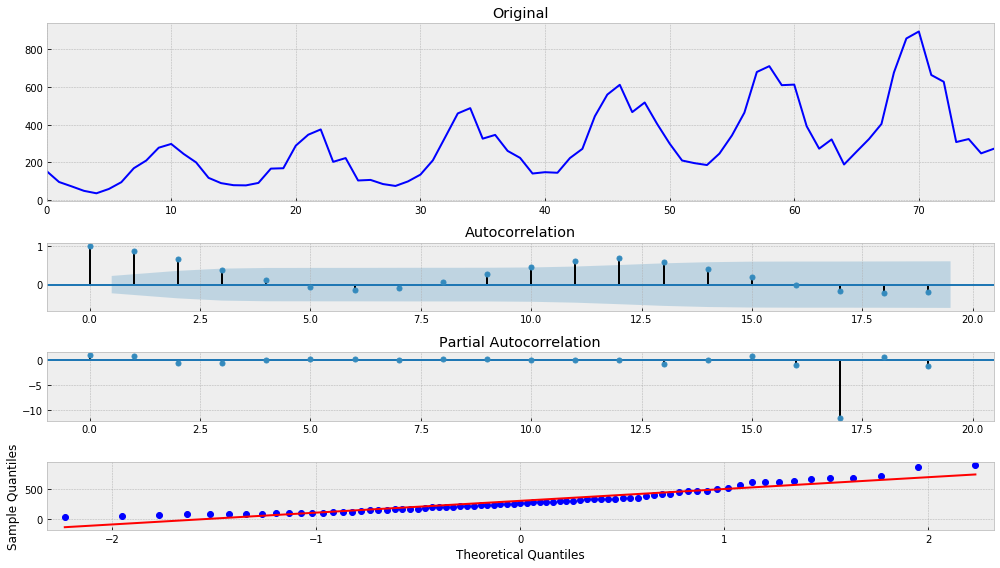

In [10]:
tsplot(X)

Как видно, наш ряд не стационарен, приведем его к стационарному виду.
Будем использовать метод Бокса-Кокса и дифференцирование. 

In [11]:
from scipy.stats import boxcox

In [12]:
X = boxcox(X, 0)

In [13]:
X = np.diff(X, 1)

In [14]:
dftest = adfuller(X, autolag='AIC')
pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

Test Statistic                 -3.135644
p-value                         0.024025
#Lags Used                     11.000000
Number of Observations Used    64.000000
dtype: float64

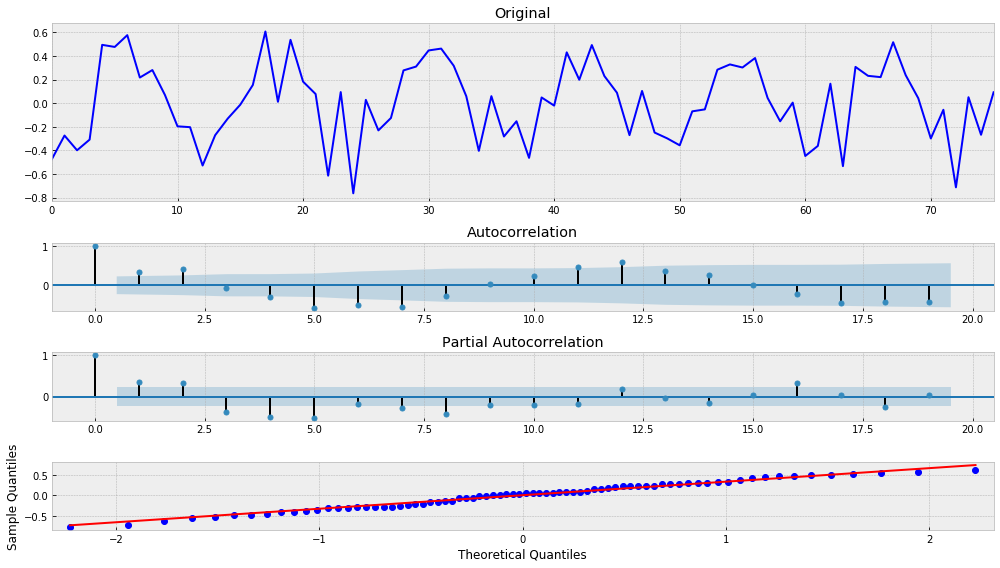

In [15]:
tsplot(X)

Применим метод ARIMA

/home/lena/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: -33.21456 | order: (3, 0, 2)
Test Statistic                 -3.135644
p-value                         0.024025
#Lags Used                     11.000000
Number of Observations Used    64.000000
dtype: float64


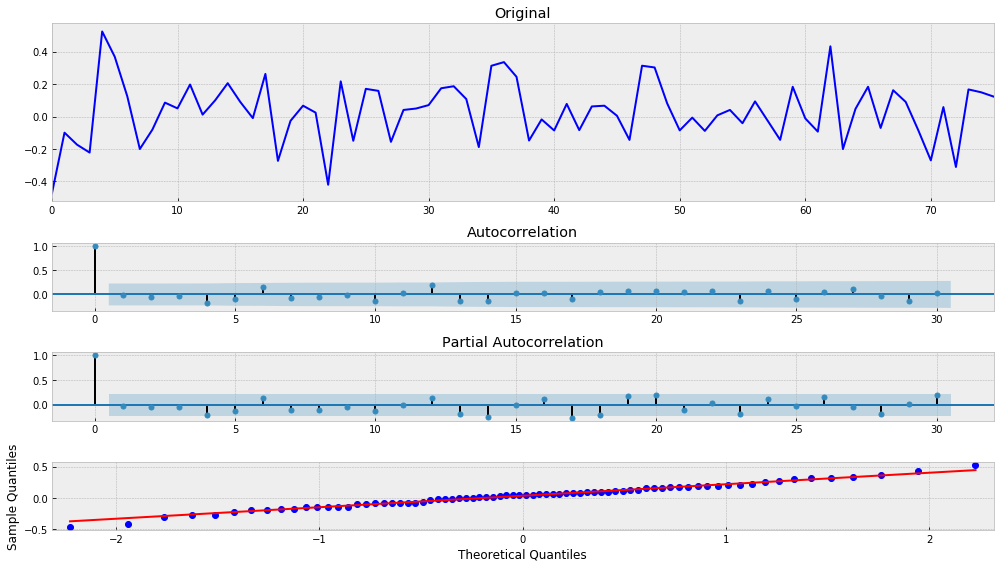

In [16]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(X, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
order = best_order
dftest = adfuller(X, autolag='AIC')
print(pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']))

tsplot(best_mdl.resid, lags=30)

In [17]:
pred = best_mdl.predict(0, 90)

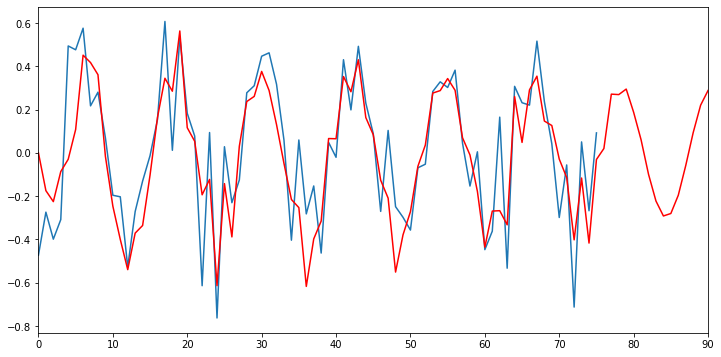

In [18]:
pd.Series(X).plot(figsize=(12,6))
pd.Series(pred).plot(style='r')

Применим метод GARCH. Коэффициенты берем из метода ARIMA

In [19]:
from arch import arch_model

In [20]:
p_ = order[0]
o_ = order[1]
q_ = order[2]


am = arch_model(X, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                      -0.001
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                            GARCH   Log-Likelihood:               -21.8882
Distribution:      Standardized Student's t   AIC:                           59.7764
Method:                  Maximum Likelihood   BIC:                           78.4222
                                              No. Observations:                   76
Date:                      Tue, Aug 25 2020   Df Residuals:                       68
Time:                              21:24:08   Df Model:                            8
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

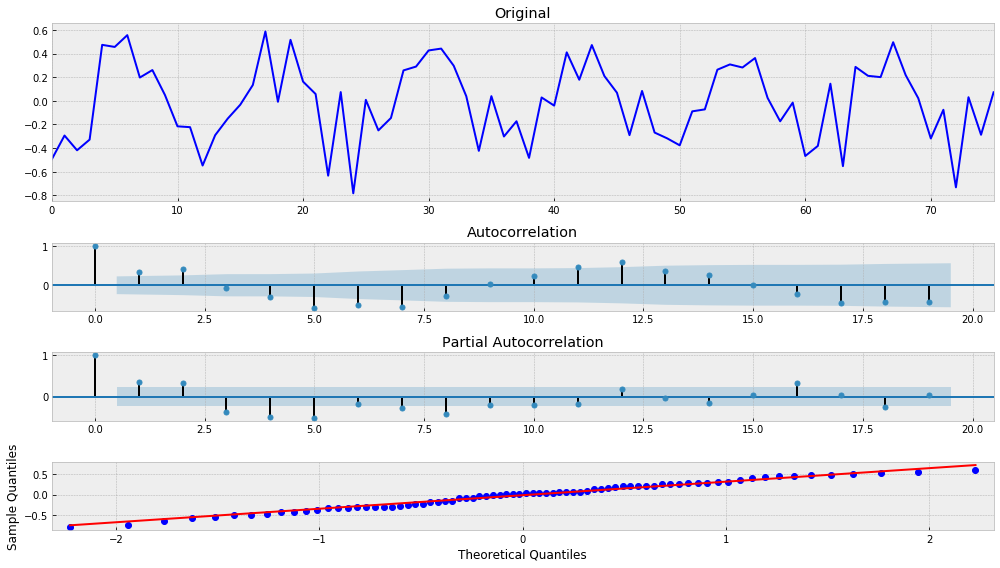

In [21]:
tsplot(res.resid)

Попробуем сделать прогноз, используя методы классического ML: LinearRegression и RandomForest

In [22]:
X = df.Count
X = boxcox(X, 0)
X = np.diff(X, 1)
X = pd.DataFrame(X)
X.columns = ['Count']
X.head()

,Count
0,-0.472604
1,-0.273889
2,-0.398639
3,-0.308301
4,0.494019


In [23]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    
    return X_train, X_test, y_train, y_test

In [24]:
X_train, X_test, y_train, y_test = prepareData(X, lag_start=1, lag_end=20, test_size=0.3)

0.030693011584573833


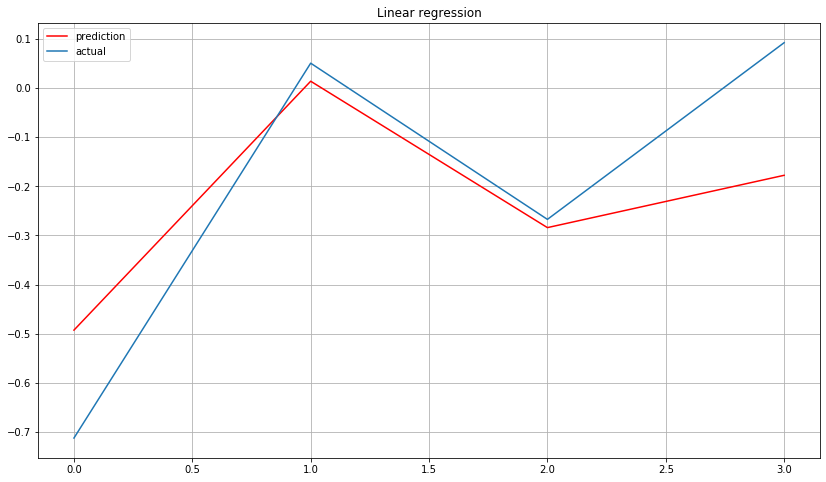

In [25]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test,prediction))

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

0.05165559226806657


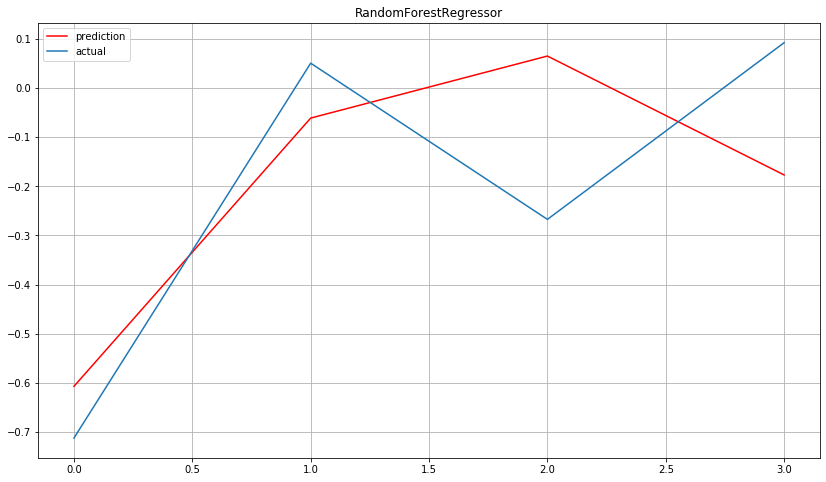

In [26]:
from sklearn.ensemble import RandomForestRegressor

lr = RandomForestRegressor()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
print(mean_squared_error(y_test,prediction))

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("RandomForestRegressor")
plt.grid(True);

По MSE получается, что линейная регрессия предпочтительнее. 